# 1. Install Dependencies and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
%cd /content/drive/MyDrive/senior-project/CNNs/

/content/drive/MyDrive/senior-project/CNNs


In [3]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [4]:
!pip install opencv-python matplotlib

In [5]:
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.5.0
bs4                           0.

In [6]:
import tensorflow as tf
import os

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [9]:
import cv2
import imghdr

# 3. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
data = tf.keras.utils.image_dataset_from_directory('data',image_size=(48, 48),color_mode='grayscale')

Found 8898 files belonging to 2 classes.


In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

In [17]:
# fig, ax = plt.subplots(ncols=1, figsize=(48,48))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[0.10588235],
          [0.11372549],
          [0.1254902 ],
          ...,
          [0.8       ],
          [0.79607844],
          [0.79607844]],
 
         [[0.09411765],
          [0.09019608],
          [0.13725491],
          ...,
          [0.8       ],
          [0.79607844],
          [0.7921569 ]],
 
         [[0.0627451 ],
          [0.09019608],
          [0.10980392],
          ...,
          [0.79607844],
          [0.79607844],
          [0.7921569 ]],
 
         ...,
 
         [[0.02745098],
          [0.04705882],
          [0.09411765],
          ...,
          [0.7058824 ],
          [0.7019608 ],
          [0.69803923]],
 
         [[0.00392157],
          [0.07843138],
          [0.13725491],
          ...,
          [0.64705884],
          [0.7019608 ],
          [0.6862745 ]],
 
         [[0.01960784],
          [0.08627451],
          [0.14509805],
          ...,
          [0.64705884],
          [0.61960787],
          [0.67058825]]],
 
 
        [

# 5. Split Data

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [21]:
train_size

195

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [23]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(48, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0

# 7. Train

In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
195/195 [==============================] - 46s 232ms/step - loss: 0.6883 - accuracy: 0.5361 - val_loss: 0.6640 - val_accuracy: 0.6750
Epoch 2/20
195/195 [==============================] - 36s 185ms/step - loss: 0.6084 - accuracy: 0.6862 - val_loss: 0.5761 - val_accuracy: 0.7227
Epoch 3/20
195/195 [==============================] - 36s 185ms/step - loss: 0.5512 - accuracy: 0.7263 - val_loss: 0.5298 - val_accuracy: 0.7358
Epoch 4/20
195/195 [==============================] - 37s 187ms/step - loss: 0.5060 - accuracy: 0.7506 - val_loss: 0.5346 - val_accuracy: 0.7347
Epoch 5/20
195/195 [==============================] - 37s 186ms/step - loss: 0.4803 - accuracy: 0.7684 - val_loss: 0.4934 - val_accuracy: 0.7602
Epoch 6/20
195/195 [==============================] - 38s 192ms/step - loss: 0.4560 - accuracy: 0.7803 - val_loss: 0.4895 - val_accuracy: 0.7585
Epoch 7/20
195/195 [==============================] - 27s 136ms/step - loss: 0.4303 - accuracy: 0.7994 - val_loss: 0.4612 - val_ac

# 8. Plot Performance

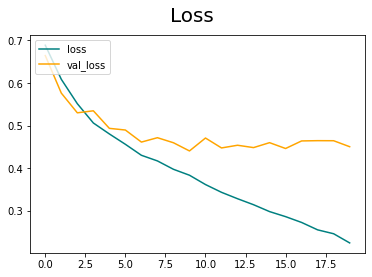

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

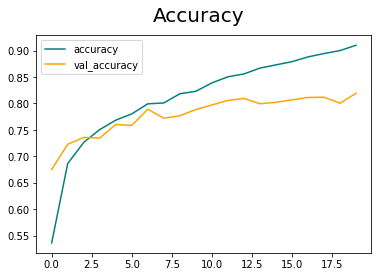

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.7641278, shape=(), dtype=float32) tf.Tensor(0.7422434, shape=(), dtype=float32) tf.Tensor(0.7638889, shape=(), dtype=float32)


# 10. Test

In [38]:
import cv2

In [39]:
!ls

 data			     face_model.json   london.txt   person-10222.jpeg
'Deep Face Detection'	     fer2013.csv       model.json   test.mp4
 Face_Emotion_detection.h5   logs	       models


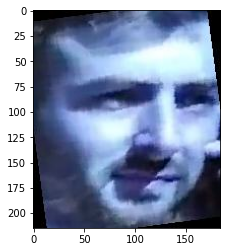

In [40]:
img = cv2.imread('person-10222.jpeg')
plt.imshow(img)
plt.show()

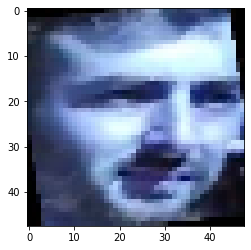

In [41]:
resize = tf.image.resize(img, (48,48))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
# yhat = model.predict(np.expand_dims(resize/255, 0))

In [43]:
# yhat

In [44]:
# if yhat > 0.5: 
#     print(f'Predicted class is not Happy')
# else:
#     print(f'Predicted class is Happy')

# 11. Save the Model

In [45]:
from tensorflow.keras.models import load_model

In [51]:
model.save('imageclassifier.h5')

In [52]:
new_model = load_model('imageclassifier.h5')

In [53]:
new_model.predict(np.expand_dims(resize/255, 0))

ValueError: ignored